# Vision Transformer
We implement a Vision Transformer (ViT) model from [Dosovitskiy, et. al. ](https://arxiv.org/pdf/2010.11929.pdf). 

Complete Repositories: 
[GitHub](https://github.com/nadeny/VisionTransformer), [GDrive](https://drive.google.com/drive/folders/1-zT5w5xQ0wGMy1Nb4XnmuyBY79Ck0N5D?usp=sharing)


# Description


## Datasets

This project employs [ImageNet-2012](https://academictorrents.com/collection/imagenet-2012).

Classes  : 1000 [categories](https://github.com/juliensimon/aws/blob/master/mxnet/imagenet/synsets_with_descriptions.txt)

Train set: 1.280.171

Test set : 50.000

## Model Architecture
Backbone : Transformer 12 layers

MHA : 12

token size : 768

input size : [3, 384, 384]

ViT Patch : [16, 16]

output size : 1000

Trainable Parameters : **86.859.496**

## Training Environment
IDE   : Pycharm-Professional 2021-03

Accl. : 3 RTX3090 @24GB - RAM 128GB

API   : Torch 1.10.0


## Training Report
Batch Number : 1024

Optimizer    : Adam

Loss         : Soft-labeling Crossentropy

Test Accuracy : **0.803**

Training and validation result are reported on [Wandb page](https://wandb.ai/nadenny/Mini%20Transformer%20Reproduce/reports/Vision-Transformer--VmlldzoxMjc2ODk5?accessToken=0c8c0pxzxurrzs5rsxzfjrl0p1q0f7z6mq610mwryf95kiimioxn8cpaosexlovz)



# Model Architecture

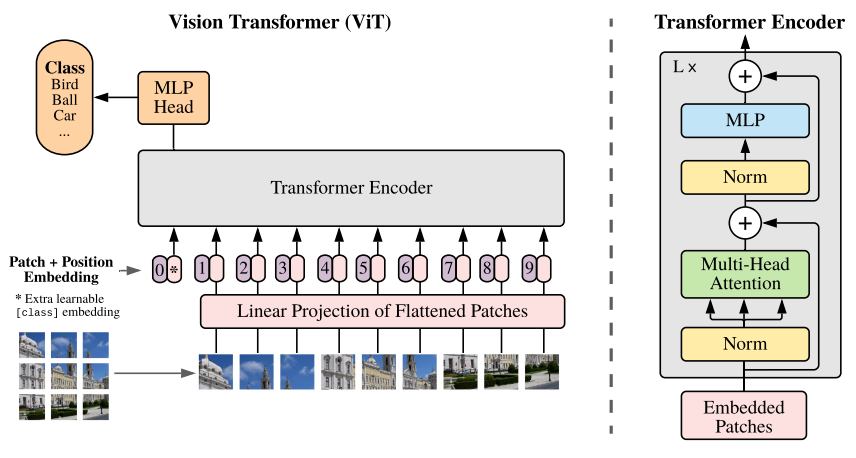

1. Patch Embedding & Linear Projection
2. Class Embedding
3. Position Embedding
4. Transformer Encoder
5. Multi-layer Perceptron

## Requirements

In [1]:
import numpy as np
from PIL import Image
import json
import os
import glob
import matplotlib.pyplot as plt
import cv2

import torch
from torch import nn
from torch import Tensor
from torch.nn import functional as F
from torchvision import transforms

!pip show torch

Name: torch
Version: 1.10.0+cu111
Summary: Tensors and Dynamic neural networks in Python with strong GPU acceleration
Home-page: https://pytorch.org/
Author: PyTorch Team
Author-email: packages@pytorch.org
License: BSD-3
Location: /usr/local/lib/python3.7/dist-packages
Requires: typing-extensions
Required-by: torchvision, torchtext, torchaudio, fastai


## Position Embedding

In [2]:
class PositionEmbedding(nn.Module):
    def __init__(self, input_seq, d_model):
        super().__init__()
        self.position_embedding = nn.Parameter(torch.zeros(1, input_seq, d_model))

    def forward(self, x):
        x = x + self.position_embedding
        return x

## Multi-Head Attention

In [3]:
class MHA(nn.Module):
    def __init__(self, d_model, nhead, dropout):
        super(MHA, self).__init__()
        self.q = nn.Linear(d_model, d_model)
        self.k = nn.Linear(d_model, d_model)
        self.v = nn.Linear(d_model, d_model)
        self.dropout = nn.Dropout(dropout)
        self.nhead = nhead
        self.scores = None

    def forward(self, x):
        q = self.q(x)
        k = self.k(x)
        v = self.v(x)
        q, k, v = (self.split(x, (self.nhead, -1)).transpose(1, 2) for x in [q, k, v])
        scores = q @ k.transpose(-2, -1) / np.sqrt(k.size(-1))
        scores = self.dropout(F.softmax(scores, dim=-1))
        h = (scores @ v).transpose(1, 2).contiguous()
        h = self.merge(h, 2)
        self.scores = scores
        return h, scores

    def split(self, x, shape):
        shape = list(shape)
        assert shape.count(-1) <= 1
        if -1 in shape:
            shape[shape.index(-1)] = int(x.size(-1) / -np.prod(shape))
        return x.view(*x.size()[:-1], *shape)

    def merge(self, x, n_dims):
        s = x.size()
        assert 1 < n_dims < len(s)
        return x.view(*s[:-n_dims], -1)

## Feed Forward Layer

In [4]:
class FeedForward(nn.Module):
    def __init__(self, d_model, d_ff):
        super(FeedForward, self).__init__()
        self.ff1 = nn.Linear(in_features=d_model, out_features=d_ff)
        self.ff2 = nn.Linear(in_features=d_ff, out_features=d_model)

    def forward(self, x):
        x = self.ff2(F.gelu(self.ff1(x)))
        return x

## Transformer Layer

### Transformer Encoder Layer

In [5]:
class TransformerEncoderLayer(nn.Module):
    def __init__(self, d_model, nhead, d_ff, dropout):
        super().__init__()
        self.attn = MHA(d_model=d_model, nhead=nhead, dropout=dropout)
        self.linproj = nn.Linear(in_features=d_model, out_features=d_model)
        self.norm1 = nn.LayerNorm(normalized_shape=d_model, eps=1e-6)

        self.ff = FeedForward(d_model=d_model, d_ff=d_ff)
        self.norm2 = nn.LayerNorm(normalized_shape=d_model, eps=1e-6)
        self.dropout = nn.Dropout(dropout)

    def forward(self, x):
        h, scores = self.attn(self.norm1(x))
        h = self.dropout(self.linproj(h))
        x = x + h
        h = self.dropout(self.ff(self.norm2(x)))
        x = x + h
        return x, scores

### Transformer layer

In [6]:
class TransformerEncoder(nn.Module):
    def __init__(self, num_layers, d_model, nhead, d_ff, dropout):
        super(TransformerEncoder, self).__init__()
        self.blocks = nn.ModuleList([
            TransformerEncoderLayer(d_model, nhead, d_ff, dropout) for _ in range(num_layers)])

    def forward(self, x):
        scores = []
        for block in self.blocks:
            x, score = block(x)
            scores.append(score)
        return x, scores

## Vision Transformer

In [7]:
class VisionTransformer(nn.Module):

    def __init__(self,
            patches=(16, 16),
            d_model=768,

            d_ff=3072,
            num_heads=12,
            num_layers=12,
            dropout=0.1,
            image_size=(3, 384, 384),
            num_classes=1000,):
        super(VisionTransformer, self).__init__()

        self.image_size = image_size

        # Image and patch sizes
        c, h, w = image_size  # image sizes
        fh, fw = patches  # patch sizes
        gh, gw = h // fh, w // fw  # number of patches
        seq_len = gh * gw

        # Patch embedding
        self.patch_embedding = nn.Conv2d(c, d_model, kernel_size=(fh, fw), stride=(fh, fw))

        # Class token
        self.class_embedding = nn.Parameter(torch.zeros(1, 1, d_model))

        # Positional embedding
        self.position_embedding = PositionEmbedding(input_seq=(seq_len+1), d_model=d_model)

        # Transformer
        self.transformer = TransformerEncoder(num_layers=num_layers, d_model=d_model, nhead=num_heads,
                                              d_ff=d_ff, dropout=dropout)

        # Classifier head
        self.norm = nn.LayerNorm(normalized_shape=d_model, eps=1e-6)
        self.mlp = nn.Linear(in_features=d_model, out_features=num_classes)

    def forward(self, x):
        b, c, fh, fw = x.shape
        x = self.patch_embedding(x)  # b,d,gh,gw
        x = x.flatten(2).transpose(1, 2)  # b,gh*gw,d
        x = torch.cat((self.class_embedding.expand(b, -1, -1), x), dim=1)  # b,gh*gw+1,d
        x = self.position_embedding(x)  # b,gh*gw+1,d
        x, scores = self.transformer(x)  # b,gh*gw+1,d
        x = self.norm(x)[:, 0]  # b,d
        x = self.mlp(x)  # b,num_classes
        return x, scores

# Accessing Dataset

### Mounting Drive

In [12]:
from google.colab import drive
drive.mount('/content/gdrive')

parent_dir = '/content/gdrive/MyDrive/ViT_Project'

Drive already mounted at /content/gdrive; to attempt to forcibly remount, call drive.mount("/content/gdrive", force_remount=True).


### Accessing Label

In [9]:
# Load class names
label_path = os.path.join(parent_dir, 'labels_map.txt')
labels_map = json.load(open(label_path))
labels_map = [labels_map[str(i)] for i in range(1000)]

# Model Implementation

### Implementation and Load parameter

In [10]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f'Available device: {device}')

Available device: cuda


In [11]:
model = VisionTransformer()
model.to(device)

param_path = os.path.join(parent_dir, 'models.pth')
state_dict = torch.load(param_path)
model.load_state_dict(state_dict)

<All keys matched successfully>

### Inference

path: /content/gdrive/MyDrive/ViT_Project/inference_images/img1.jpg | Prediction Result: 


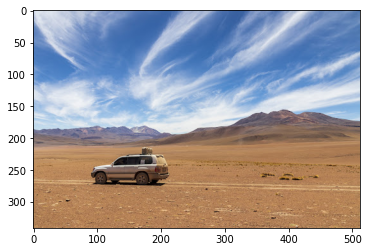

[980]	 volcano                                                                     (17.561%)
[979]	 valley, vale                                                                (9.024%)
[609]	 jeep, landrover                                                             (7.607%)
[436]	 beach wagon, station wagon, wagon, estate car, beach waggon, station waggon, waggon (6.887%)
[511]	 convertible                                                                 (6.542%)


path: /content/gdrive/MyDrive/ViT_Project/inference_images/img2.jpg | Prediction Result: 


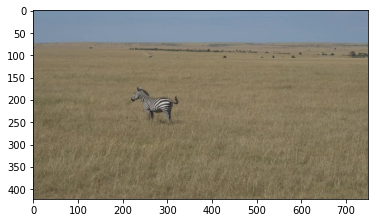

[340]	 zebra                                                                       (99.517%)
[353]	 gazelle                                                                     (0.091%)
[351]	 hartebeest                                                                  (0.068%)
[343]	 warthog                                                                     (0.038%)
[352]	 impala, Aepyceros melampus                                                  (0.034%)




In [20]:
model.eval()

for f in glob.iglob('/content/gdrive/MyDrive/ViT_Project/inference_images/*.jpg'):
    print(f'path: {f} | Prediction Result: ')
    img = Image.open(f)
    plt.imshow(img)
    plt.show()

    tfms = transforms.Compose([transforms.Resize((384, 384)), transforms.ToTensor(),
                               transforms.Normalize([0.5, 0.5, 0.5], [0.5, 0.5, 0.5]), ])
    img = tfms(img).unsqueeze(0)

    img = img.to(device)
    with torch.no_grad():
        outputs, _ = model(img)
        outputs = outputs.squeeze(0)
    for idx in torch.topk(outputs, k=5).indices.tolist():
        prob = torch.softmax(outputs, -1)[idx].item()
        print('[{idx}]\t {label:<75} ({p:.3f}%)'.format(idx=idx, label=labels_map[idx], p=prob * 100))
    print('\n')

### Inspect ViT

In [21]:
# Test Image

tfms = transforms.Compose([transforms.Resize((384, 384)), transforms.ToTensor(),
                               transforms.Normalize([0.5, 0.5, 0.5], [0.5, 0.5, 0.5]), ])

im = Image.open('/content/gdrive/MyDrive/ViT_Project/inference_images/img2.jpg')
img = tfms(im).unsqueeze(0)
img = img.to(device)

Thanks [Jeonsworld](https://github.com/jeonsworld/ViT-pytorch/blob/main/visualize_attention_map.ipynb)

In [22]:
outputs, scores = model(img)
scores = torch.stack(scores).squeeze(1)
scores = scores.to('cpu')
# Average the attention weights across all heads.
scores = torch.mean(scores, dim=1)

# To account for residual connections, we add an identity matrix to the
# attention matrix and re-normalize the weights.
residual_score= torch.eye(scores.size(1))
aug_score = scores + residual_score
aug_score = aug_score / aug_score.sum(dim=-1).unsqueeze(-1)

# Recursively multiply the weight matrices
joint_attentions = torch.zeros(aug_score.size())
joint_attentions[0] = aug_score[0]

for n in range(1, aug_score.size(0)):
    joint_attentions[n] = torch.matmul(aug_score[n], joint_attentions[n - 1])

# Attention from the output token to the input space.
v = joint_attentions[-1]
grid_size = int(np.sqrt(aug_score.size(-1)))
mask = v[0, 1:].reshape(grid_size, grid_size).detach().numpy()
mask = cv2.resize(mask / mask.max(), im.size)[..., np.newaxis]
result = (mask * im).astype("uint8")

Prediction Label and Attention Map!

[340]	 zebra                                                                       (99.517%)
[353]	 gazelle                                                                     (0.091%)
[351]	 hartebeest                                                                  (0.068%)
[343]	 warthog                                                                     (0.038%)
[352]	 impala, Aepyceros melampus                                                  (0.034%)
[293]	 cheetah, chetah, Acinonyx jubatus                                           (0.030%)
[9]	 ostrich, Struthio camelus                                                   (0.023%)
[276]	 hyena, hyaena                                                               (0.022%)
[386]	 African elephant, Loxodonta africana                                        (0.013%)
[138]	 bustard                                                                     (0.011%)


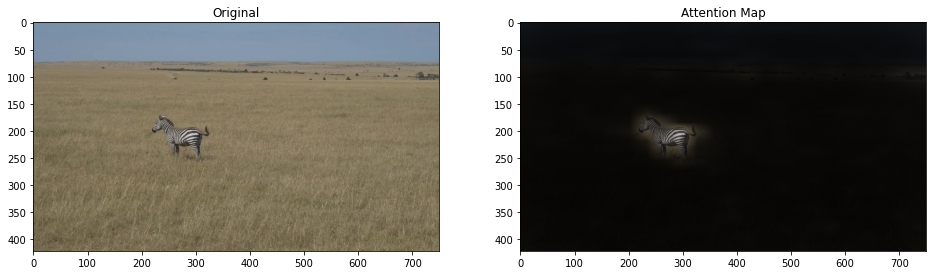

In [23]:
fig, (ax1, ax2) = plt.subplots(ncols=2, figsize=(16, 16))

ax1.set_title('Original')
ax2.set_title('Attention Map')

ax1.imshow(im)
ax2.imshow(result)

print("Prediction Label and Attention Map!\n")
outputs = outputs.squeeze(0)
for idx in torch.topk(outputs, k=10).indices.tolist():
    prob = torch.softmax(outputs, -1)[idx].item()
    print('[{idx}]\t {label:<75} ({p:.3f}%)'.format(idx=idx, label=labels_map[idx], p=prob * 100))

Prediction Label and Attention Map!

[980]	 volcano                                                                     (17.561%)
[979]	 valley, vale                                                                (9.024%)
[609]	 jeep, landrover                                                             (7.607%)
[436]	 beach wagon, station wagon, wagon, estate car, beach waggon, station waggon, waggon (6.887%)
[511]	 convertible                                                                 (6.542%)
[656]	 minivan                                                                     (5.090%)
[627]	 limousine, limo                                                             (4.051%)
[717]	 pickup, pickup truck                                                        (4.028%)
[915]	 yurt                                                                        (3.432%)
[581]	 grille, radiator grille                                                     (2.666%)


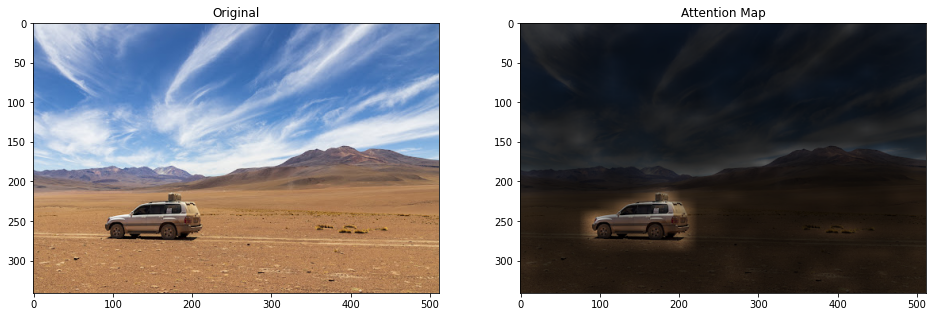

In [24]:
# Test Image

tfms = transforms.Compose([transforms.Resize((384, 384)), transforms.ToTensor(),
                               transforms.Normalize([0.5, 0.5, 0.5], [0.5, 0.5, 0.5]), ])

im = Image.open('/content/gdrive/MyDrive/ViT_Project/inference_images/img1.jpg')
img = tfms(im).unsqueeze(0)
img = img.to(device)

outputs, scores = model(img)
scores = torch.stack(scores).squeeze(1)
scores = scores.to('cpu')
# Average the attention weights across all heads.
scores = torch.mean(scores, dim=1)

# To account for residual connections, we add an identity matrix to the
# attention matrix and re-normalize the weights.
residual_score= torch.eye(scores.size(1))
aug_score = scores + residual_score
aug_score = aug_score / aug_score.sum(dim=-1).unsqueeze(-1)

# Recursively multiply the weight matrices
joint_attentions = torch.zeros(aug_score.size())
joint_attentions[0] = aug_score[0]

for n in range(1, aug_score.size(0)):
    joint_attentions[n] = torch.matmul(aug_score[n], joint_attentions[n - 1])

# Attention from the output token to the input space.
v = joint_attentions[-1]
grid_size = int(np.sqrt(aug_score.size(-1)))
mask = v[0, 1:].reshape(grid_size, grid_size).detach().numpy()
mask = cv2.resize(mask / mask.max(), im.size)[..., np.newaxis]
result = (mask * im).astype("uint8")

fig, (ax1, ax2) = plt.subplots(ncols=2, figsize=(16, 16))

ax1.set_title('Original')
ax2.set_title('Attention Map')

ax1.imshow(im)
ax2.imshow(result)

print("Prediction Label and Attention Map!\n")
outputs = outputs.squeeze(0)
for idx in torch.topk(outputs, k=10).indices.tolist():
    prob = torch.softmax(outputs, -1)[idx].item()
    print('[{idx}]\t {label:<75} ({p:.3f}%)'.format(idx=idx, label=labels_map[idx], p=prob * 100))

### To Inprove

- Multi-objects classification
- Stronger regularization to achieve better performance